# Import Packages

In [62]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt
import sagemaker
import boto3
from sagemaker import Session
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV
from sagemaker.amazon.amazon_estimator import get_image_uri 

# Creating S3 Bucket

In [2]:
bucket_name = 'customerloyalty12'
my_region = boto3.session.Session().region_name # set the region of the instance
print(my_region)

us-east-1


In [3]:
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name)
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


# set an output path where the trained model will be saved

In [4]:
prefix = 'linear_learner'
output_path ='s3://{}/{}/output'.format(bucket_name, prefix)
print(output_path)

s3://customerloyalty12/linear_learner/output


In [5]:
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::455001515037:role/service-role/AmazonSageMaker-ExecutionRole-20230314T231345


# Importing dataset

In [6]:
import pickle
try:
    model_data = pickle.load(open('./abc_reg_modelling.p','rb'))
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: Data loaded into dataframe.


# Exploratory Data Analysis

In [7]:
model_data.head()

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,toatl_sales_cost,num_items,transactions_id,product_area_id,average_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800


In [8]:
## drop unneccessary columns
model_data= model_data.drop(["customer_id"], axis=1)

In [9]:
### shuffle the data
model_data = shuffle(model_data, random_state=42)

In [10]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 455 to 219
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   distance_from_store     398 non-null    float64
 1   gender                  397 non-null    object 
 2   credit_score            398 non-null    float64
 3   customer_loyalty_score  400 non-null    float64
 4   toatl_sales_cost        400 non-null    float64
 5   num_items               400 non-null    int64  
 6   transactions_id         400 non-null    int64  
 7   product_area_id         400 non-null    int64  
 8   average_basket_value    400 non-null    float64
dtypes: float64(5), int64(3), object(1)
memory usage: 31.2+ KB


In [11]:
model_data.describe()

,distance_from_store,credit_score,customer_loyalty_score,toatl_sales_cost,num_items,transactions_id,product_area_id,average_basket_value
count,398.000000,398.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000
mean,2.032261,0.596156,0.507413,1848.377300,278.19000,44.920000,4.315000,36.869348
std,2.561213,0.101267,0.293870,1759.946742,213.02077,21.155199,0.722551,19.353272
min,0.000000,0.260000,0.002000,45.950000,10.00000,4.000000,2.000000,9.342000
25%,0.712500,0.530000,0.262000,942.522500,201.00000,41.000000,4.000000,22.464754
50%,1.655000,0.590000,0.508500,1471.490000,259.00000,50.000000,4.000000,30.365417
75%,2.917500,0.660000,0.770500,2116.720000,319.25000,53.000000,5.000000,47.300978
max,44.370000,0.880000,1.000000,9878.760000,1187.00000,109.000000,5.000000,102.335417


In [12]:
model_data['gender'].value_counts()

F    226
M    171
Name: gender, dtype: int64

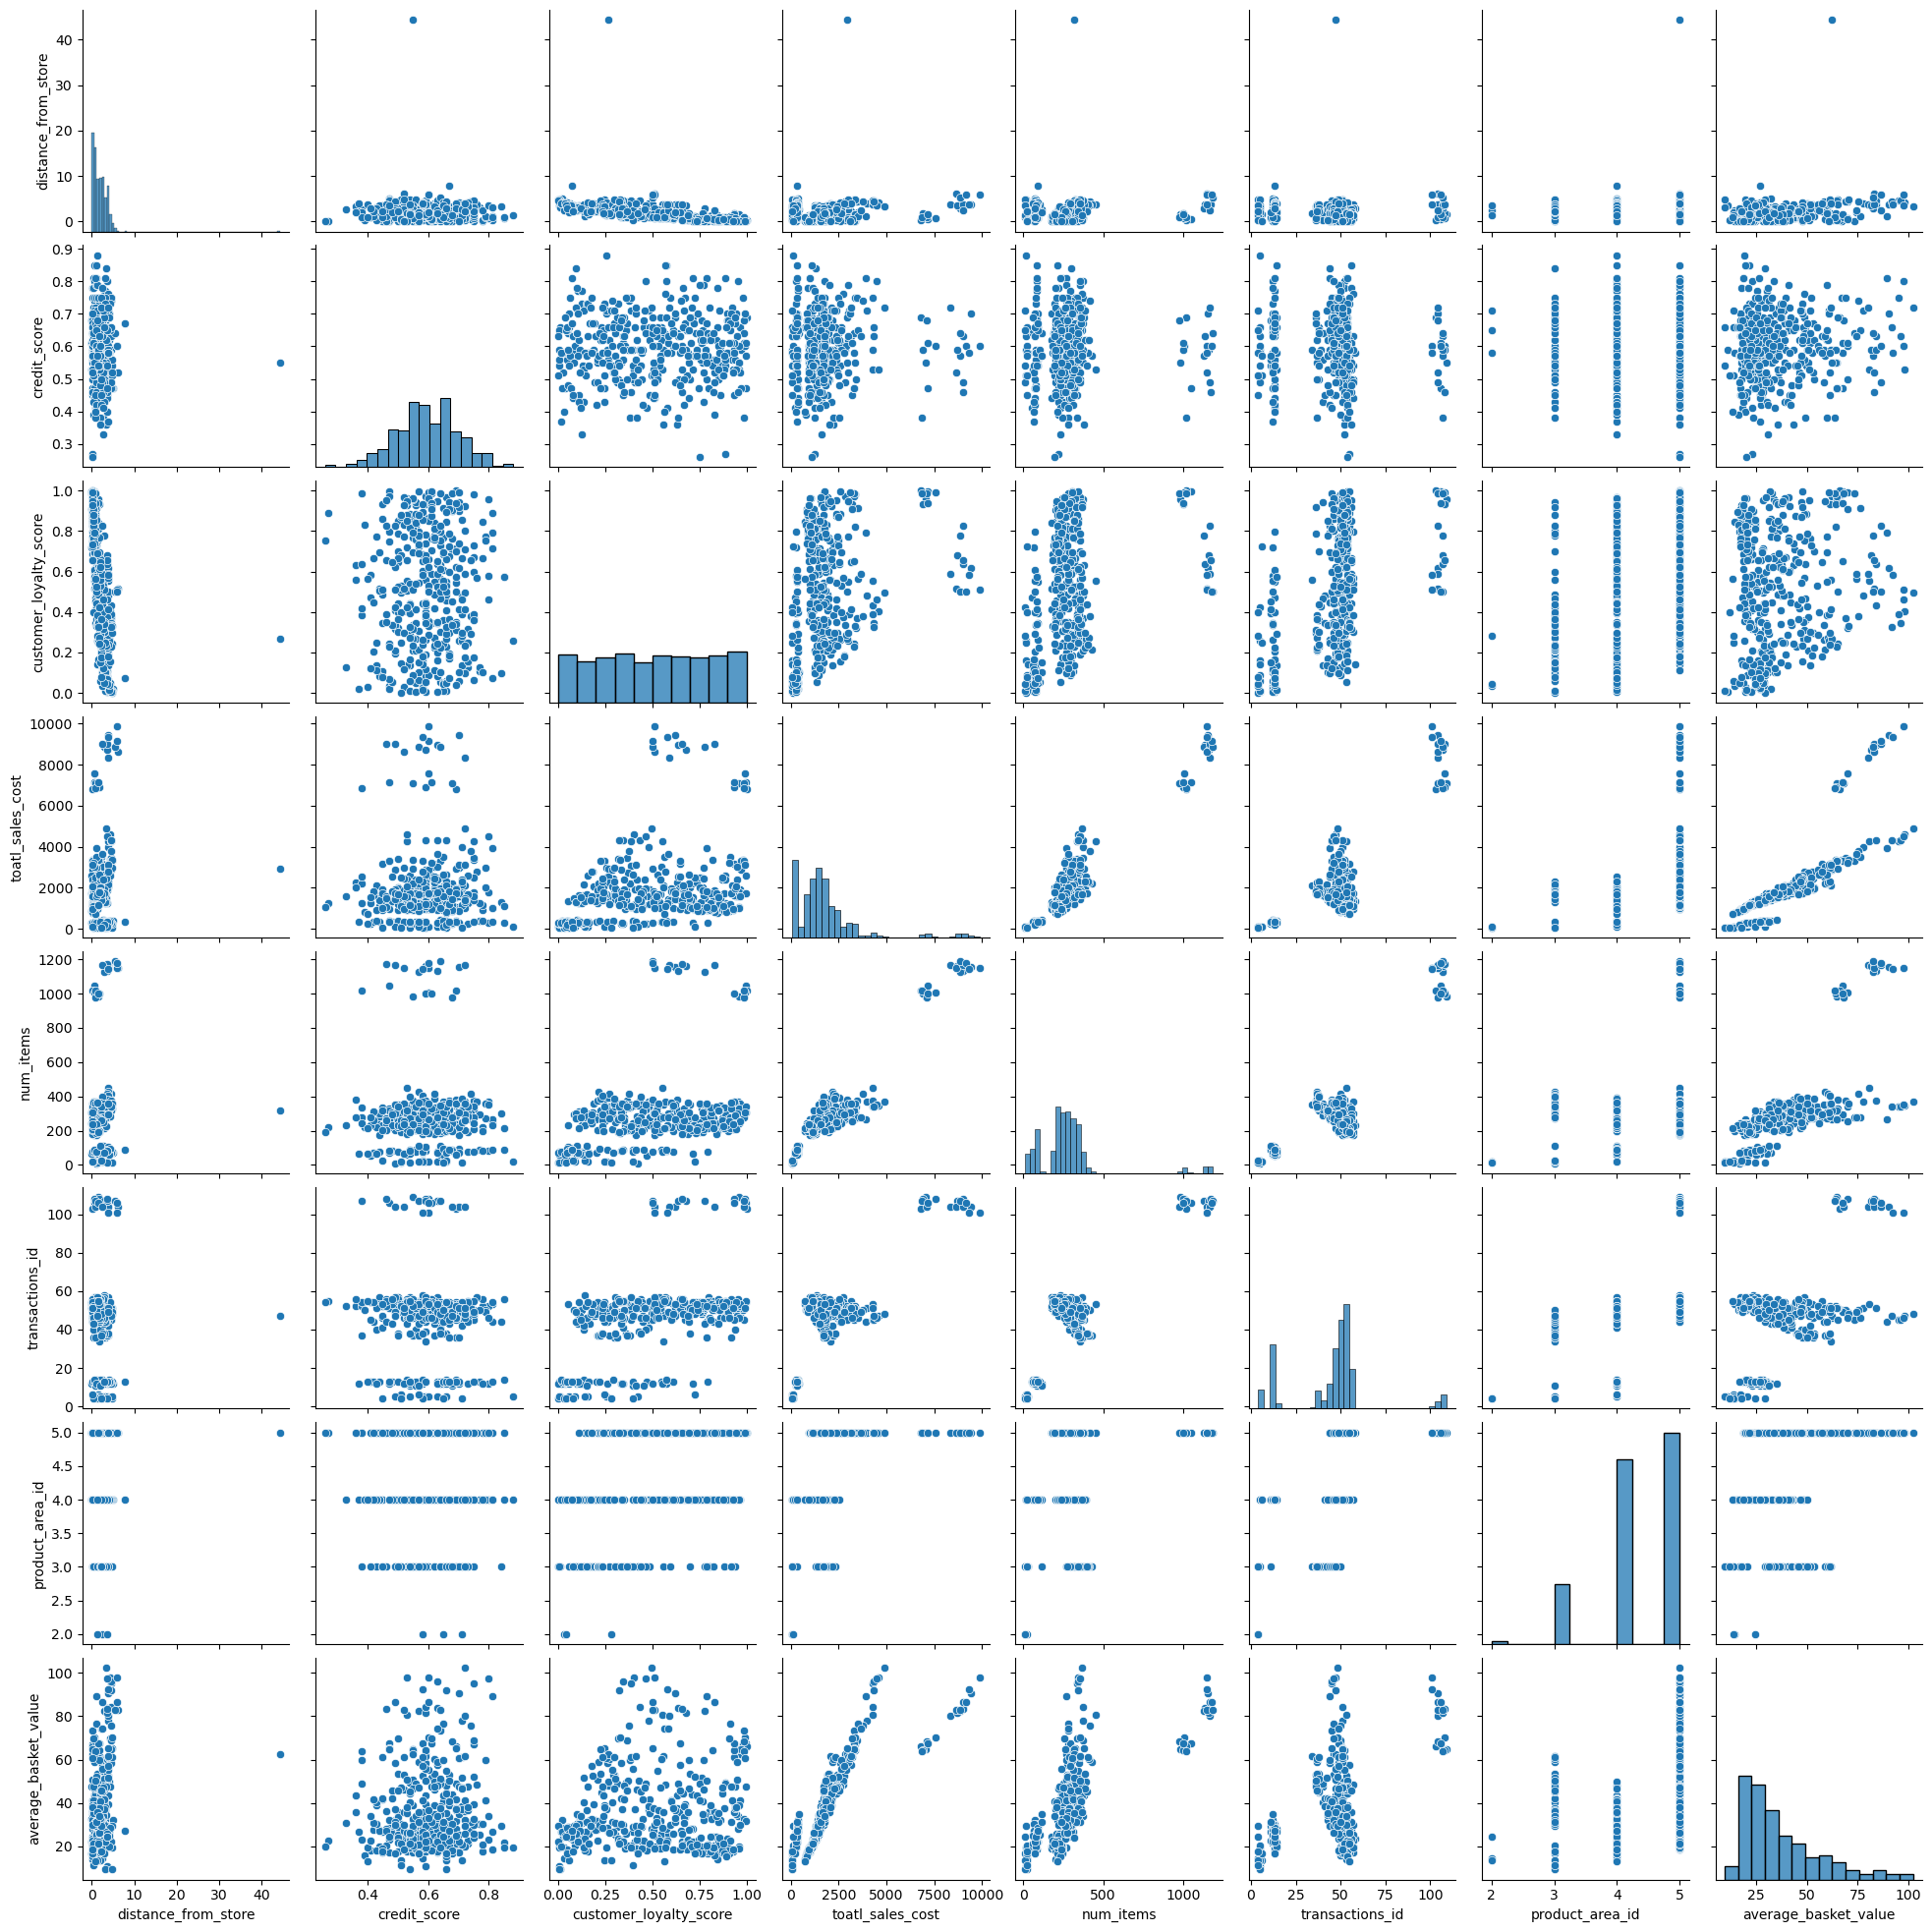

In [13]:
sns.pairplot(model_data)

In [14]:
model_data.columns

Index(['distance_from_store', 'gender', 'credit_score',
       'customer_loyalty_score', 'toatl_sales_cost', 'num_items',
       'transactions_id', 'product_area_id', 'average_basket_value'],
      dtype='object')

array([[<AxesSubplot: title={'center': 'distance_from_store'}>,
        <AxesSubplot: title={'center': 'credit_score'}>,
        <AxesSubplot: title={'center': 'customer_loyalty_score'}>],
       [<AxesSubplot: title={'center': 'toatl_sales_cost'}>,
        <AxesSubplot: title={'center': 'num_items'}>,
        <AxesSubplot: title={'center': 'transactions_id'}>],
       [<AxesSubplot: title={'center': 'product_area_id'}>,
        <AxesSubplot: title={'center': 'average_basket_value'}>,
        <AxesSubplot: >]], dtype=object)

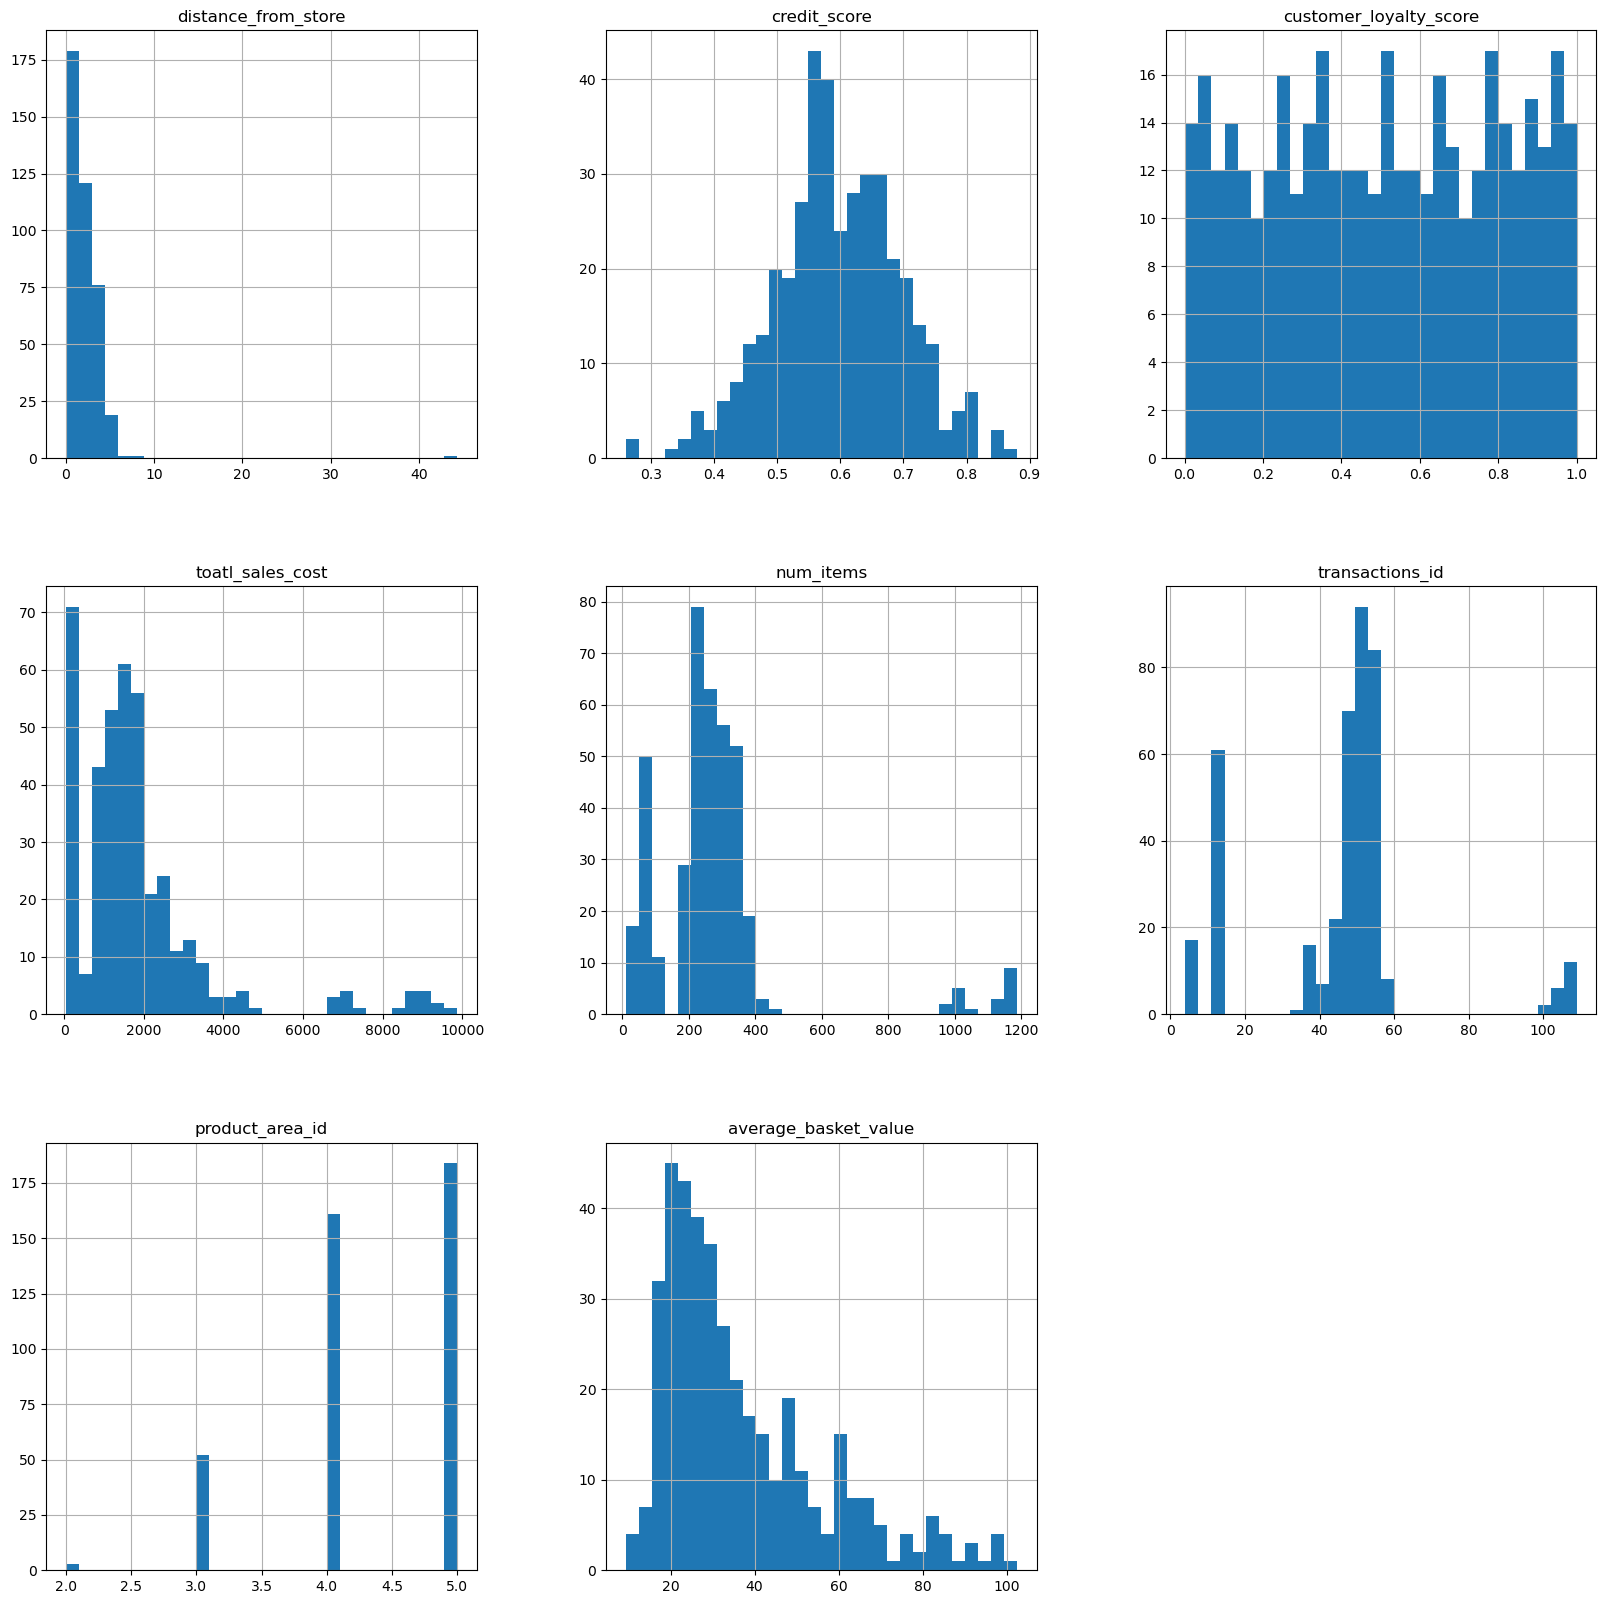

In [15]:
model_data[['distance_from_store', 'gender', 'credit_score',
       'customer_loyalty_score', 'toatl_sales_cost', 'num_items',
       'transactions_id', 'product_area_id', 'average_basket_value']].hist(bins = 30, figsize = (20,20))


In [16]:
model_data.isna().sum()
model_data.dropna(how="any", inplace =True)

In [17]:
model_data.isna().sum()

distance_from_store       0
gender                    0
credit_score              0
customer_loyalty_score    0
toatl_sales_cost          0
num_items                 0
transactions_id           0
product_area_id           0
average_basket_value      0
dtype: int64

In [18]:
## Outliers detection
outlier_column=["distance_from_store","toatl_sales_cost",
               "num_items", "credit_score", "customer_loyalty_score", "average_basket_value" ]
for column in outlier_column:
    
    lower_qrt=model_data[column].quantile(0.25)
    upper_qrt=model_data[column].quantile(0.75)  
    inetrqrt_range = upper_qrt - lower_qrt
    Lower_boundary = lower_qrt - (inetrqrt_range* 2)
    Upper_boundary = upper_qrt + (inetrqrt_range* 2)
    outliers = model_data[(model_data[column] < Lower_boundary) | (model_data[column] > Upper_boundary)].index
    
    print(f"there were {len(outliers)} outliers detecetd")
    
    model_data.drop(outliers, inplace=True)

there were 2 outliers detecetd
there were 23 outliers detecetd
there were 0 outliers detecetd
there were 1 outliers detecetd
there were 0 outliers detecetd
there were 5 outliers detecetd


In [19]:
X =model_data.drop(["customer_loyalty_score"], axis=1)
X.head()

,distance_from_store,gender,credit_score,toatl_sales_cost,num_items,transactions_id,product_area_id,average_basket_value
455,0.28,M,0.81,990.65,243,53,4,18.691509
621,2.58,F,0.58,333.26,70,13,4,25.635385
64,0.80,M,0.80,1753.96,371,52,5,33.730000
456,0.16,M,0.56,929.57,225,51,4,18.226863
196,3.27,F,0.67,1904.55,376,36,3,52.904167


In [20]:
y=model_data["customer_loyalty_score"]

# Splitting the train and test data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# One hot encoding (categorical variable)

In [22]:
encoder= OneHotEncoder(sparse=False,drop= "first")
cat_vars=["gender"]
X_train_encoder=encoder.fit_transform(X_train[cat_vars])
X_test_encoder=encoder.transform(X_test[cat_vars])
feature_names= encoder.get_feature_names_out(cat_vars)

X_train_encoder =pd.DataFrame(X_train_encoder, columns = feature_names)
X_train = pd.concat([X_train.reset_index(drop=True), X_train_encoder.reset_index(drop=True)],axis=1)
X_train.drop(cat_vars, axis =1, inplace=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [23]:
X_test_encoder =pd.DataFrame(X_test_encoder, columns = feature_names)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_encoder.reset_index(drop=True)],axis=1)
X_test.drop(cat_vars, axis =1, inplace=True)

In [24]:
X_train.head(5)

,distance_from_store,credit_score,toatl_sales_cost,num_items,transactions_id,product_area_id,average_basket_value,gender_M
0,0.50,0.59,938.02,239,53,4,17.698491,0.0
1,0.19,0.57,1096.96,202,53,5,20.697358,1.0
2,0.08,0.52,946.85,237,51,4,18.565686,1.0
3,0.91,0.54,2388.31,272,54,5,44.227963,1.0
4,3.55,0.55,1878.05,375,37,3,50.758108,0.0


In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)


In [26]:
X_train = np.array(X_train).astype('float32')

In [27]:
X_test = scaler.transform(X_test)
X_test = np.array(X_test).astype('float32')

In [28]:
y_train = np.array(y_train).astype('float32')
y_test = np.array(y_test).astype('float32')

# Placing the data into S3 bucket

In [29]:
import io # The io module allows for dealing with various types of I/O (text I/O, binary I/O and raw I/O). 
import sagemaker.amazon.common as smac # sagemaker common libary

buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
smac.write_numpy_to_dense_tensor(buf, X_train, y_train.reshape(-1))
buf.seek(0) 
# When you write to in-memory byte arrays, it increments 1 every time you write to it
# Let's reset that back to zero 


0

In [30]:
import os
key = 'linear-train-data'
boto3.resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket_name, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://customerloyalty12/linear_learner/train/linear-train-data


In [31]:
# create an output placeholder in S3 bucket to store the linear learner output

output_location = 's3://{}/{}/output'.format(bucket_name, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://customerloyalty12/linear_learner/output


# Train a Linear regression model using SageMaker

In [32]:
## Let's obtain a reference to the linearLearner container image
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [33]:
# construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(container,
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1, 
                                          instance_type='ml.m5.2xlarge', 
                                          volume_size=5, # 5 GB 
                                          output_path=output_location,
                                          use_spot_instances=True,
                                          max_run=300,
                                          max_wait=600)
                                          
                                        

In [34]:
estimator.set_hyperparameters(feature_dim = 8,
                           predictor_type = 'regressor',
                           mini_batch_size = 100,
                           epochs = 100,
                           num_models = 32,
                           loss = 'absolute_loss')

In [35]:
estimator.fit({'train': s3_train_data})

INFO:sagemaker:Creating training-job with name: linear-learner-2023-03-16-00-43-48-574


2023-03-16 00:43:48 Starting - Starting the training job...
2023-03-16 00:44:07 Starting - Preparing the instances for training.........
2023-03-16 00:45:36 Downloading - Downloading input data...
2023-03-16 00:46:02 Training - Downloading the training image......
2023-03-16 00:46:53 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/16/2023 00:47:10 INFO 140232109598528] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss':

# Deploying the model to perform inference 

In [39]:

linear_regressor = estimator.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m5.xlarge')

INFO:sagemaker:Creating model with name: linear-learner-2023-03-16-00-50-00-500
INFO:sagemaker:Creating endpoint-config with name linear-learner-2023-03-16-00-50-00-500
INFO:sagemaker:Creating endpoint with name linear-learner-2023-03-16-00-50-00-500


-------!

In [40]:
from sagemaker.predictor import csv_serializer, json_deserializer

In [41]:
# linear_regressor.content_type = 'text/csv'
linear_regressor.serializer = csv_serializer
linear_regressor.deserializer = json_deserializer

# Evaluation of the model

In [42]:
result = linear_regressor.predict(X_test)
result

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


{'predictions': [{'score': 0.36828818917274475},
  {'score': 0.7751476764678955},
  {'score': -0.1753460168838501},
  {'score': 0.8696309328079224},
  {'score': 0.49049878120422363},
  {'score': -0.36897486448287964},
  {'score': 0.8357750177383423},
  {'score': 0.2591102719306946},
  {'score': 0.6252648234367371},
  {'score': 0.30256831645965576},
  {'score': 0.6214075088500977},
  {'score': 0.32605689764022827},
  {'score': 0.6723682284355164},
  {'score': 0.4716554284095764},
  {'score': 0.2516530454158783},
  {'score': 0.4492676854133606},
  {'score': 0.3652361035346985},
  {'score': 0.4740714728832245},
  {'score': 0.5470462441444397},
  {'score': 0.38070768117904663},
  {'score': 0.716313898563385},
  {'score': 0.6469680070877075},
  {'score': 0.6327528953552246},
  {'score': 0.6767815947532654},
  {'score': 0.6885433197021484},
  {'score': 0.5912116765975952},
  {'score': 0.3709842562675476},
  {'score': 0.9916341304779053},
  {'score': -0.017695963382720947},
  {'score': 0.4465

In [43]:
predictions = np.array([r['score'] for r in result['predictions']])
predictions

array([ 0.36828819,  0.77514768, -0.17534602,  0.86963093,  0.49049878,
       -0.36897486,  0.83577502,  0.25911027,  0.62526482,  0.30256832,
        0.62140751,  0.3260569 ,  0.67236823,  0.47165543,  0.25165305,
        0.44926769,  0.3652361 ,  0.47407147,  0.54704624,  0.38070768,
        0.7163139 ,  0.64696801,  0.6327529 ,  0.67678159,  0.68854332,
        0.59121168,  0.37098426,  0.99163413, -0.01769596,  0.44654831,
        0.6051935 ,  0.89782739,  0.71460295,  0.36959571, -0.38354081,
        0.3273119 ,  0.31913003,  0.2314502 ,  0.62566036,  0.56184316,
        0.05793661,  0.80615079,  0.5406512 , -0.09676158,  0.44301891,
        0.51637739,  0.1408709 ,  0.1698592 ,  0.67887527,  0.53355718,
        0.91095889,  0.57534069,  0.5901171 ,  0.52807307,  0.7097311 ,
        0.61377764,  0.38099876,  0.70369995, -0.11715037,  0.67707503,
        0.87122184,  0.10695806,  0.49696696,  0.2454015 , -0.13155538,
        0.31133044,  0.40637389,  0.4104341 ,  0.80661505,  0.09

In [48]:
RMSE = float(format(np.sqrt(mean_squared_error(y_test, predictions)),'.3f'))
print(RMSE)

0.136


In [53]:
MSE = mean_squared_error(y_test, predictions)
MAE = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)


print('MSE =', MSE, '\nMAE =',MAE, '\nR2 =', r2)

MSE = 0.018570394472658003 
MAE = 0.10513420405236315 
R2 = 0.7954587726228717


In [54]:
## Adjusted r-square
n, k = X_test.shape
adj_r2 = 1 - (1 -r2) * (n - 1) / (n - k -1)
print(adj_r2)

0.7698911192007306


In [60]:
linear_regressor.predict([4.48897809e-01,  5.90163946e-01,  3.26650262e-01,
         6.12440169e-01,  8.14814806e-01,  6.66666687e-01,
         2.65999585e-01,  0.00000000e+00]))

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


array({'predictions': [{'score': 0.36828818917274475}]}, dtype=object)

# Delete the end-point

In [61]:

linear_regressor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: linear-learner-2023-03-16-00-50-00-500
INFO:sagemaker:Deleting endpoint with name: linear-learner-2023-03-16-00-50-00-500
